In [5]:
#DECLARAÇÃO DE BIBLIOTECAS

import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [6]:
#GERAÇÃO DE DADOS

N = 1000
X, y = make_moons(N, noise=0.1, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.c_[np.ones((len(y_train), 1)), x_train, x_train[:,0]**2, x_train[:,1]**2, x_train[:,0]**3, x_train[:,1]**3]

x_test = np.c_[np.ones((len(y_test), 1)), x_test, x_test[:,0]**2, x_test[:,1]**2, x_test[:,0]**3, x_test[:,1]**3]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [7]:
#RESTAURAÇÃO

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [8]:
#FUNÇÃO DE CRIAÇÃO DE MINI-LOTES

def random_batch(x_train, y_train, tamanho):
    indices = np.random.randint(0, len(x_train), tamanho)
    x_lote = x_train[indices]
    y_lote = y_train[indices]
    return x_lote, y_lote

In [9]:
#CRIAÇÃO DO GRAFO

reset_graph()
X = tf.placeholder(tf.float32, shape=(None, 7), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([7, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)
loss = tf.losses.log_loss(y, y_proba)
learning_rate = 0.2
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
#TENSORBOARD

from datetime import datetime
from tensorboard import notebook

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs1"
logdir = "{}/run-{}/".format(root_logdir, now)

print(logdir)

loss_summary = tf.summary.scalar('MSE', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

tf_logs1/run-20200614215527/


In [13]:
#EXECUÇÃO DO GRAFO

iteracoes = 1000
tamanho = 1
lotes = int(np.ceil(N / tamanho))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(iteracoes):
        for indice in range(lotes):
            x_lote, y_lote = random_batch(x_train, y_train, tamanho)
            sess.run(training_op, feed_dict={X: x_lote, y: y_lote})
        loss_val = loss.eval({X: x_test, y: y_test})
        
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            save_path = saver.save(sess, "./my_model.ckpt")
            
        if indice % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: x_lote, y: y_lote})
                step = epoch * lotes + indice
                file_writer.add_summary(summary_str, step)

    y_proba_val = y_proba.eval(feed_dict={X: x_test, y: y_test})
    
    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch: 0 	Loss: 0.097025536
Epoch: 100 	Loss: 0.006240809
Epoch: 200 	Loss: 0.005370921
Epoch: 300 	Loss: 0.0037275958
Epoch: 400 	Loss: 0.0029761314
Epoch: 500 	Loss: 0.0026979519
Epoch: 600 	Loss: 0.001828273
Epoch: 700 	Loss: 0.0018320663
Epoch: 800 	Loss: 0.0019516997
Epoch: 900 	Loss: 0.0014805817


In [14]:
#PRECISÃO

y_pred = (y_proba_val >= 0.5)

precisao = precision_score(y_test, y_pred)

print('Precisão: ', precisao)

Precisão:  1.0


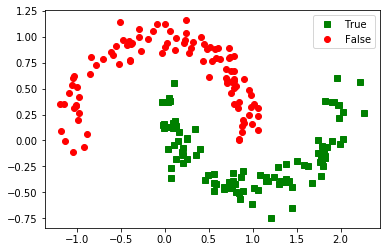

In [15]:
y_pred_idx = y_pred.reshape(-1)
plt.plot(x_test[y_pred_idx, 1], x_test[y_pred_idx, 2], 'gs', label="True")
plt.plot(x_test[~y_pred_idx, 1], x_test[~y_pred_idx, 2], 'ro', label="False")
plt.legend()
plt.show()

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

In [49]:
%tensorboard --logdir tf_logs1

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 39328.

In [ ]:
file_writer.close()